题目：

电影推荐系统

## 1.导入数据集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
mat = sio.loadmat('data/ex8_movies.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

## 2.处理数据集

In [3]:
# Y 表示用户对电影的评分 ； R 表示用户是否对电影进行了评分
Y,R = mat['Y'],mat['R']
Y.shape,R.shape

((1682, 943), (1682, 943))

In [4]:
# 给出了的参数
param_mat =sio.loadmat('data/ex8_movieParams.mat')
param_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [5]:
# nu ：用户的数量 ,nm ：电影的数量 , nf ：特征的数量
X,Theta,nu,nm,nf = param_mat['X'],param_mat['Theta'],param_mat['num_users'],param_mat['num_movies'],param_mat['num_features']

In [6]:
X.shape,Theta.shape,nu,nm,nf # 表示有943个用户 1682个电影 10和特征

((1682, 10),
 (943, 10),
 array([[943]], dtype=uint16),
 array([[1682]], dtype=uint16),
 array([[10]], dtype=uint8))

In [7]:
# 将 nu,nm,nf 改变为int型
nu = int(nu)
nm = int(nm)
nf = int(nf)
nu,nm,nf

(943, 1682, 10)

## 3.序列化参数、解序列化参数

In [8]:
# 将X,theta序列化
def serialize(X,Theta):
    
    return np.append(X.flatten(),Theta.flatten())

In [9]:
# 将X,theta反序列化
def deserialize(params,nm,nu,nf):
    X = params[:nm*nf].reshape(nm,nf)
    Theta = params[nm*nf:].reshape(nu,nf)
    return X,Theta

## 4.代价函数

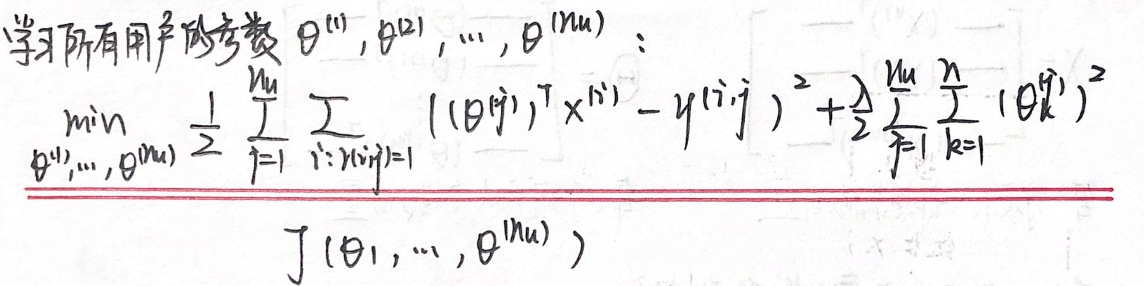

In [10]:
# 定义代价函数
def costFunction(params,Y,R,nm,nu,nf,lamda):
    
    X,Theta = deserialize(params,nm,nu,nf)
    
    error = 0.5 * np.square((X@Theta.T - Y)* R).sum()
    
    reg1 = 0.5 * lamda * np.square(X).sum()
    reg2 = 0.5 * lamda * np.square(Theta).sum()
    
    return error + reg1 + reg2

In [11]:
# 假设 有4个用户 5部电影 3个特征
users = 4
movies = 5
features = 3

X_sub = X[:movies,:features]
Theta_sub = Theta[:users,:features]
Y_sub = Y[:movies,:users]
R_sub = R[:movies,:users]

cost1 = costFunction(serialize(X_sub,Theta_sub),Y_sub,R_sub,movies,users,features,lamda = 0)
cost1

22.224603725685675

In [12]:
cost2 = costFunction(serialize(X_sub,Theta_sub),Y_sub,R_sub,movies,users,features,lamda = 1.5)
cost2

31.344056244274217

## 5.梯度下降

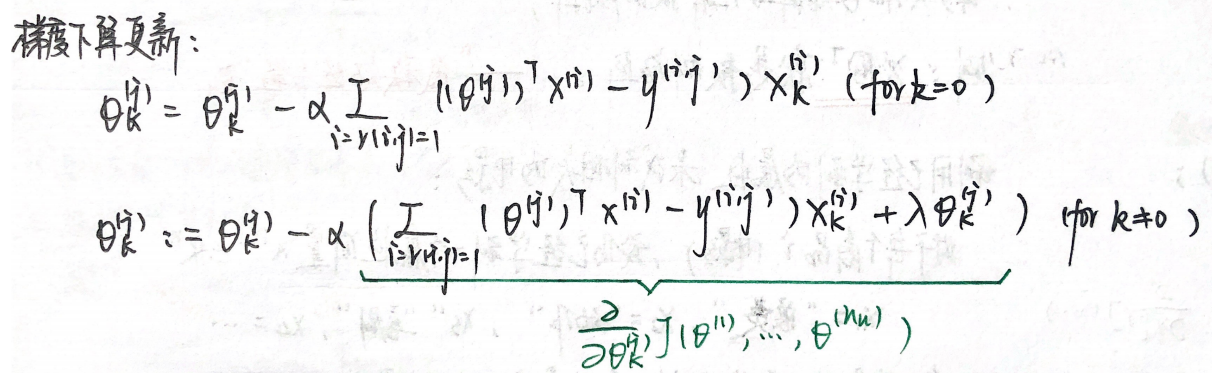

In [13]:
# 定义梯度下降算法
def costGradient(params,Y,R,nm,nu,nf,lamda):
   
    # 将 X,Theta 解序列化
    X,Theta = deserialize(params,nm,nu,nf)
    
    # 进行梯度下降
    X_grad = ((X@Theta.T-Y)*R)@Theta +lamda * X
    Theta_grad = ((X@Theta.T-Y)*R).T@X + lamda * Theta
    
    # 返回序列化的X 和 theta
    return serialize(X_grad,Theta_grad)

## 6.添加一个新用户

In [14]:
my_ratings = np.zeros((nm,1))
my_ratings[9]   = 5
my_ratings[66]  = 5
my_ratings[96]   = 5
my_ratings[121]  = 4
my_ratings[148]  = 4
my_ratings[285]  = 3
my_ratings[490]  = 4
my_ratings[599]  = 4
my_ratings[643] = 4
my_ratings[958] = 5
my_ratings[1117] = 3

In [15]:
Y = np.c_[Y,my_ratings]
R = np.c_[R,my_ratings!=0]

In [17]:
print(Y.shape)
print(R.shape)

(1682, 944)
(1682, 944)


In [18]:
nm,nu = Y.shape

## 7.均值归一化

In [19]:
# 使其平均分为0
def normalizeRatings(Y,R):
    Y_mean =(Y.sum(axis=1) / R.sum(axis=1)).reshape(-1,1)
    Y_norm = (Y - Y_mean) * R
    return Y_norm,Y_mean

In [20]:
Y_norm,Y_mean = normalizeRatings(Y,R)

## 8.参数初始化

In [21]:
X = np.random.random((nm,nf))
Theta = np.random.random((nu,nf))
params = serialize(X,Theta)
lamda = 10

## 9.模型训练

In [22]:
from scipy.optimize import minimize

# 使用最小化函数来最小化代价函数
res = minimize(fun = costFunction,
        x0 = params,
        args = (Y_norm,R,nm,nu,nf,lamda),
        method = 'TNC',
        jac = costGradient,
        options = {'maxiter':100})

In [23]:
params_fit = res.x

In [24]:
fit_X,fit_Theta = deserialize(params_fit,nm,nu,nf)

## 10.预测

In [25]:
Y_pred = fit_X@fit_Theta.T

In [26]:
y_pred = Y_pred[:,-1] + Y_mean.flatten()

In [27]:
index = np.argsort(-y_pred)

In [28]:
index[:10]

array([1499, 1292, 1535, 1200, 1598, 1652, 1466,  813, 1121, 1188],
      dtype=int64)

In [29]:
movies = []
with open('data/movie_ids.txt','r',encoding='latin 1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movies.append(' '.join(tokens[1:]))

In [30]:
len(movies)

1682

In [31]:
for i in range(10):
    print(index[i],movies[index[i]],y_pred[index[i]])

1499 Santa with Muscles (1996) 5.001478618822007
1292 Star Kid (1997) 5.000107878409937
1535 Aiqing wansui (1994) 4.999967346324024
1200 Marlene Dietrich: Shadow and Light (1996) 4.999915015935219
1598 Someone Else's America (1995) 4.9998490296004645
1652 Entertaining Angels: The Dorothy Day Story (1996) 4.999716367275518
1466 Saint of Fort Washington, The (1993) 4.999511941124905
813 Great Day in Harlem, A (1994) 4.99925109326916
1121 They Made Me a Criminal (1939) 4.9991658970174235
1188 Prefontaine (1997) 4.998624531744121
